In [218]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [219]:
country_to_predict="Afghanistan"

**ARIMA**


In [220]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
0,1970-01-01,37.409,Afghanistan
1,1971-01-01,37.930,Afghanistan
2,1972-01-01,38.461,Afghanistan
3,1973-01-01,39.003,Afghanistan
4,1974-01-01,39.558,Afghanistan


In [221]:
del df["Country"]

In [222]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [223]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

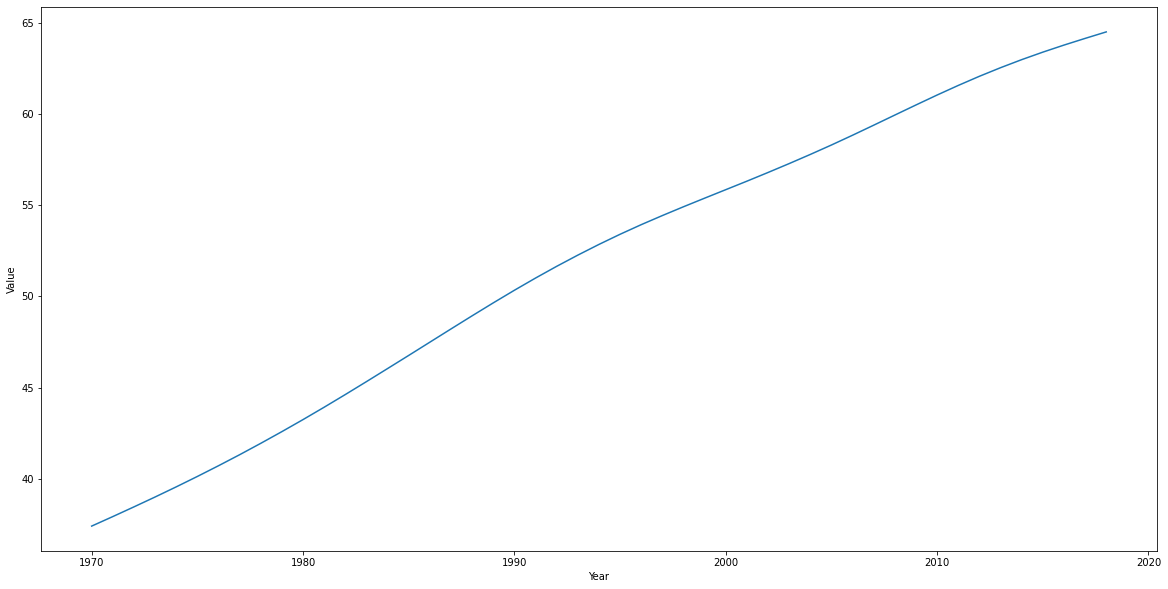

In [224]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [225]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  38.748167
1976-01-01  39.299167
1977-01-01  39.864167
1978-01-01  40.444667
1979-01-01  41.041667
1980-01-01  41.656000
1981-01-01  42.288500
1982-01-01  42.938833
1983-01-01  43.606167
1984-01-01  44.288833
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  1.016852
1976-01-01  1.041480
1977-01-01  1.069317
1978-01-01  1.100195
1979-01-01  1.132812
1980-01-01  1.166267
1981-01-01  1.200421
1982-01-01  1.233975
1983-01-01  1.265691
1984-01-01  1.294172


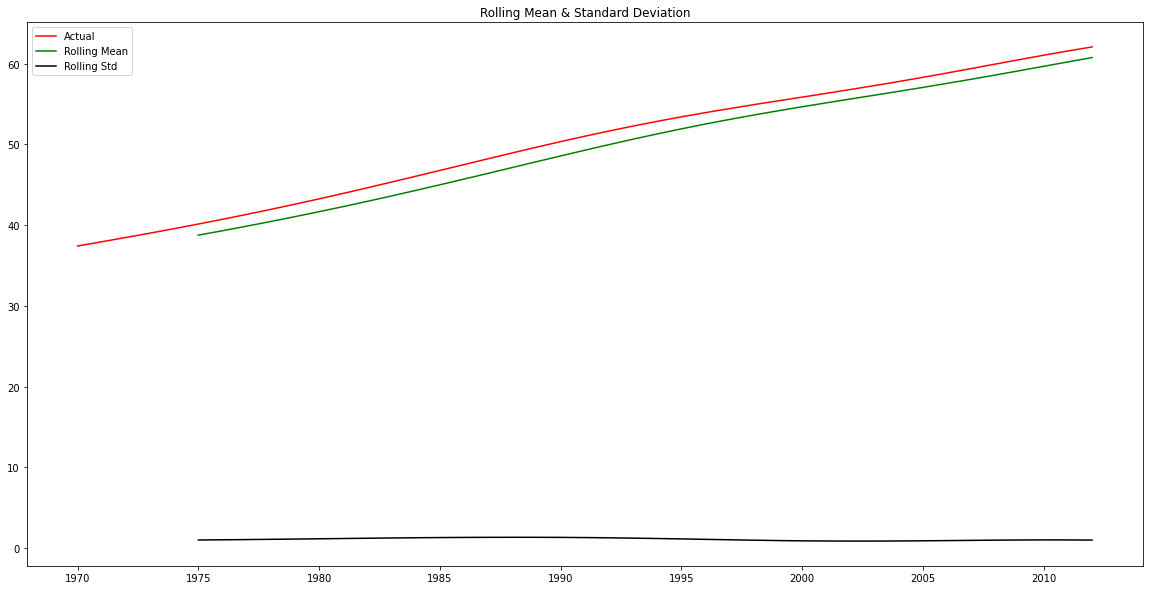

In [226]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [227]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic          -3.079604
p-value                  0.028100
Lags Used                3.000000
No. of Obs              39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
dtype: float64


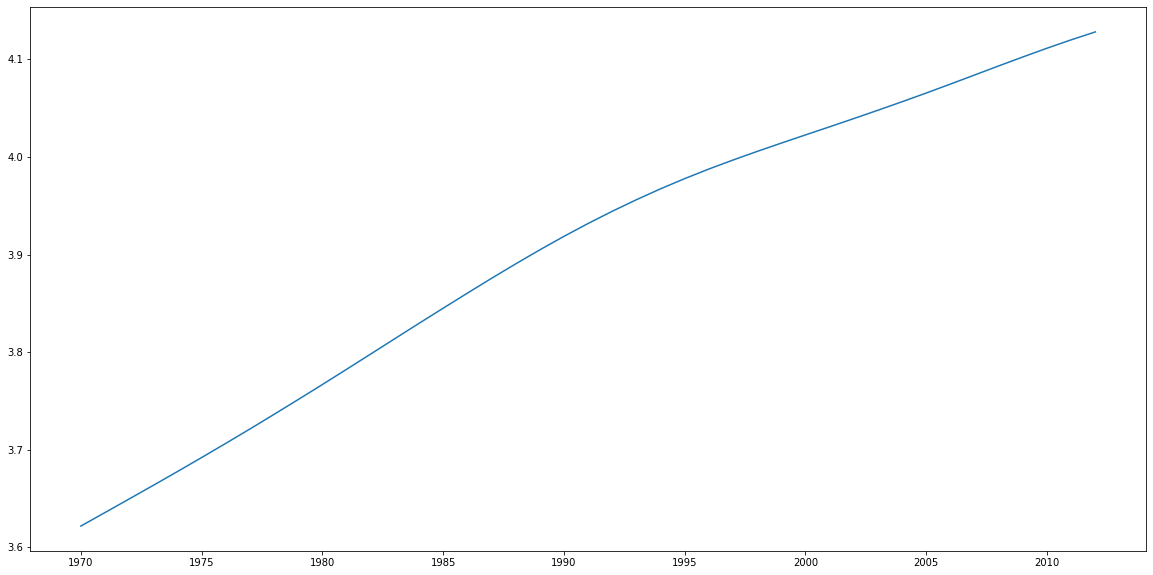

In [228]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

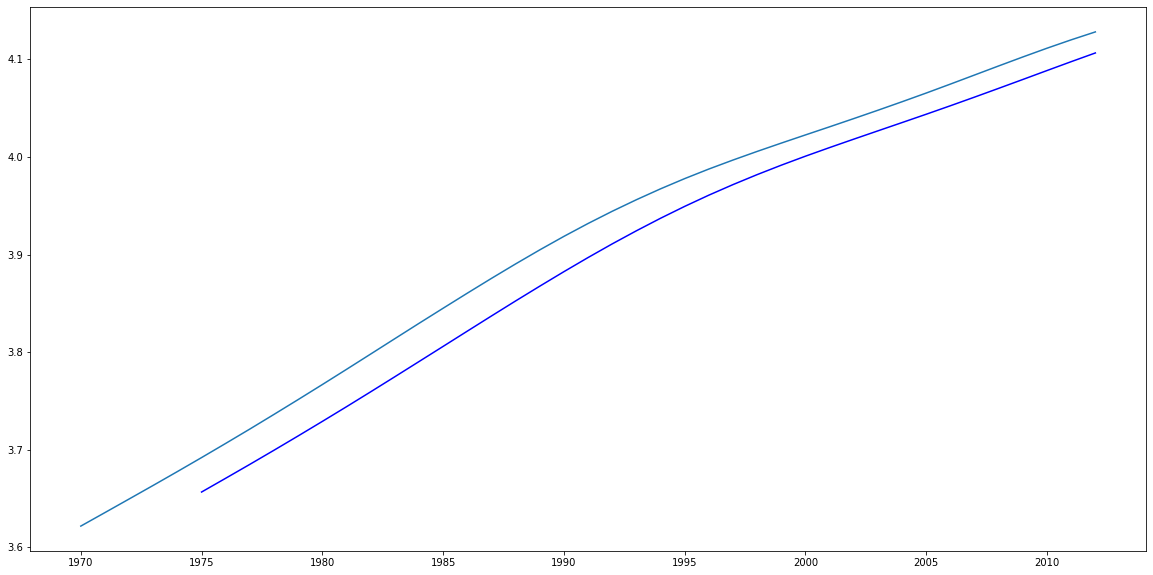

In [229]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [230]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.035278
1976-01-01,0.035686
1977-01-01,0.036169
1978-01-01,0.036709


In [231]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.035278
1976-01-01,0.035686
1977-01-01,0.036169
1978-01-01,0.036709
1979-01-01,0.037232


In [232]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

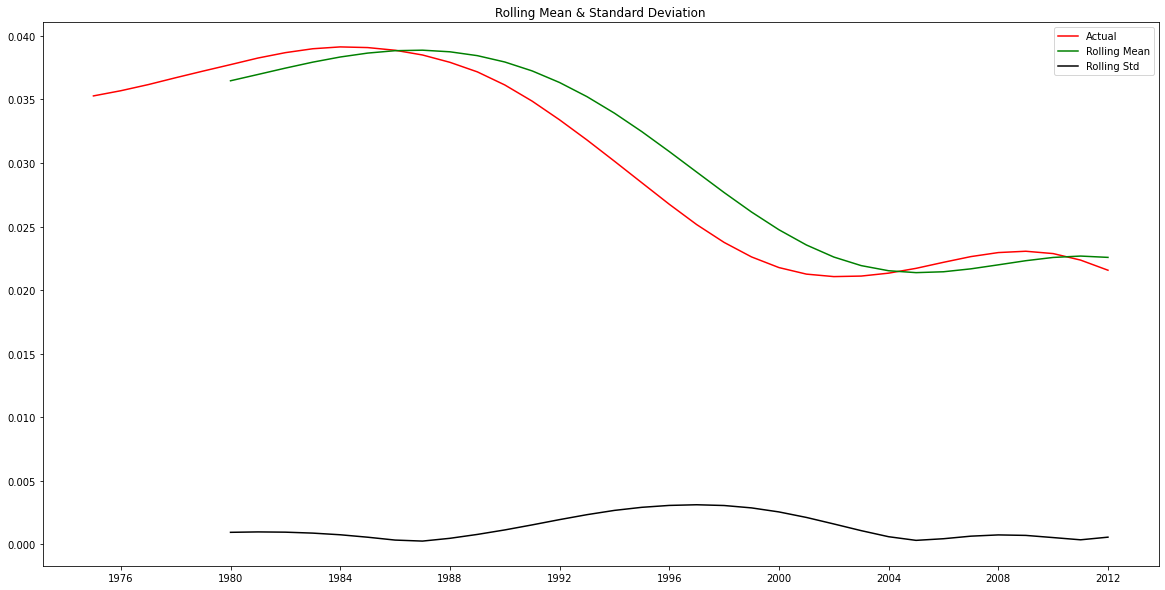

Dickey-Fuller Test: 
Test Statistic           1.553142
p-value                  0.997710
Lags Used                2.000000
No. of Obs              35.000000
Critical Value (1%)     -3.632743
Critical Value (5%)     -2.948510
Critical Value (10%)    -2.613017
dtype: float64


In [233]:
stationarity(df_log_diff)

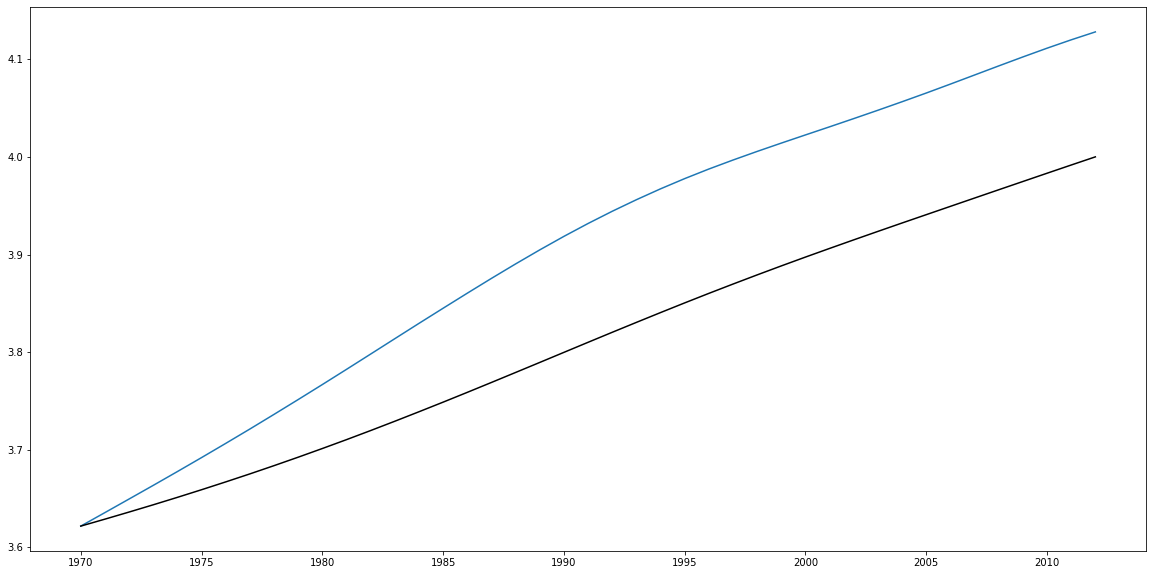

In [234]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

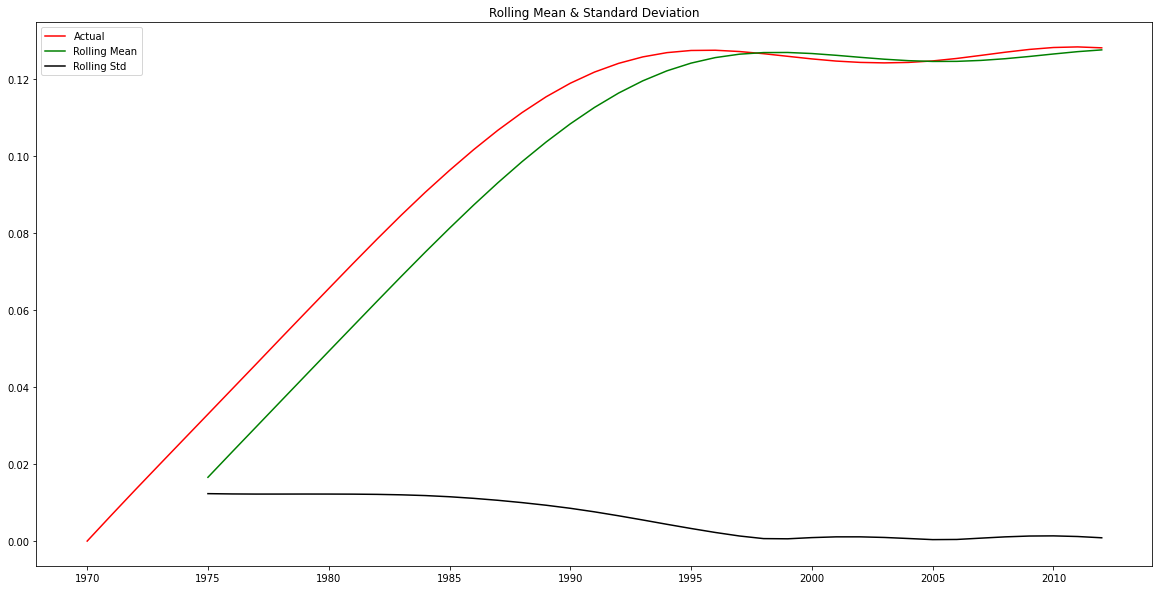

Dickey-Fuller Test: 
Test Statistic          -2.569804
p-value                  0.099400
Lags Used                8.000000
No. of Obs              34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
dtype: float64


In [235]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

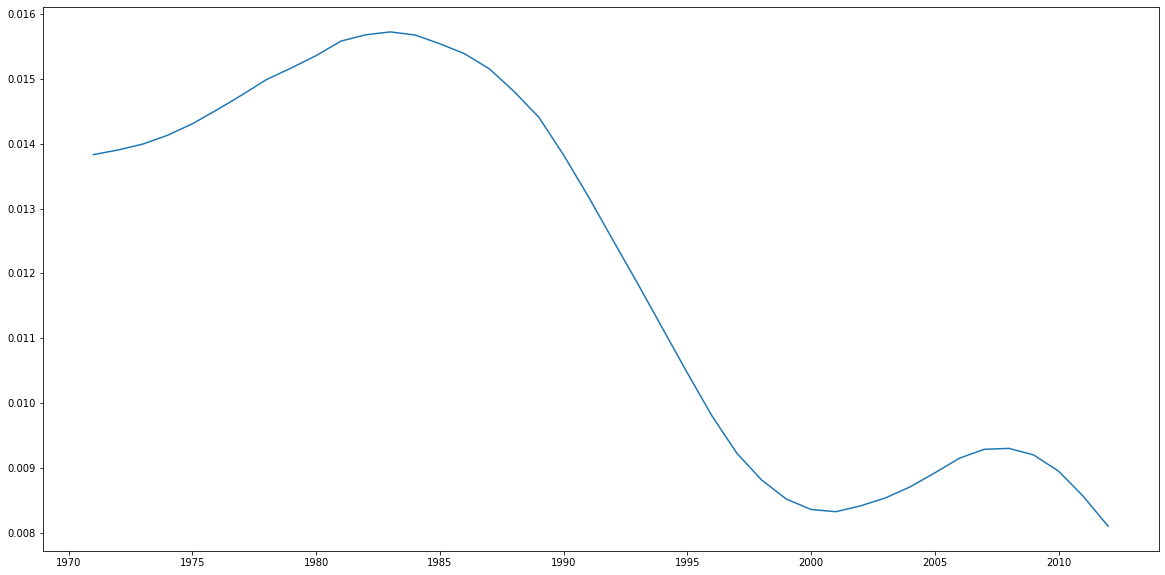

In [236]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift()
plt.plot(df_shift)

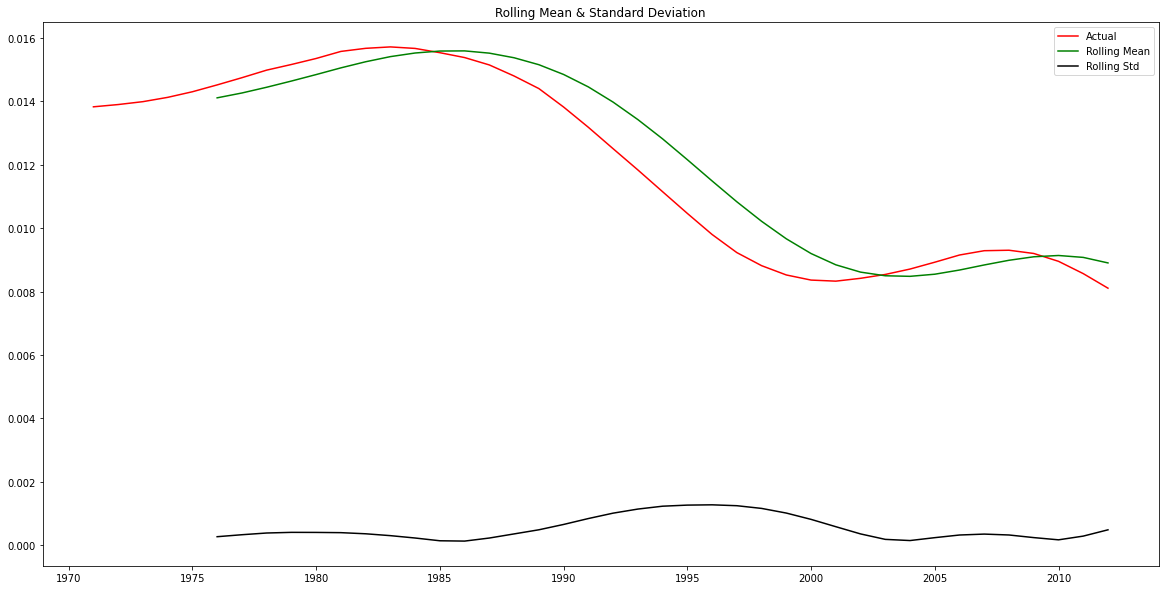

Dickey-Fuller Test: 
Test Statistic           0.742746
p-value                  0.990653
Lags Used                4.000000
No. of Obs              37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


In [237]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

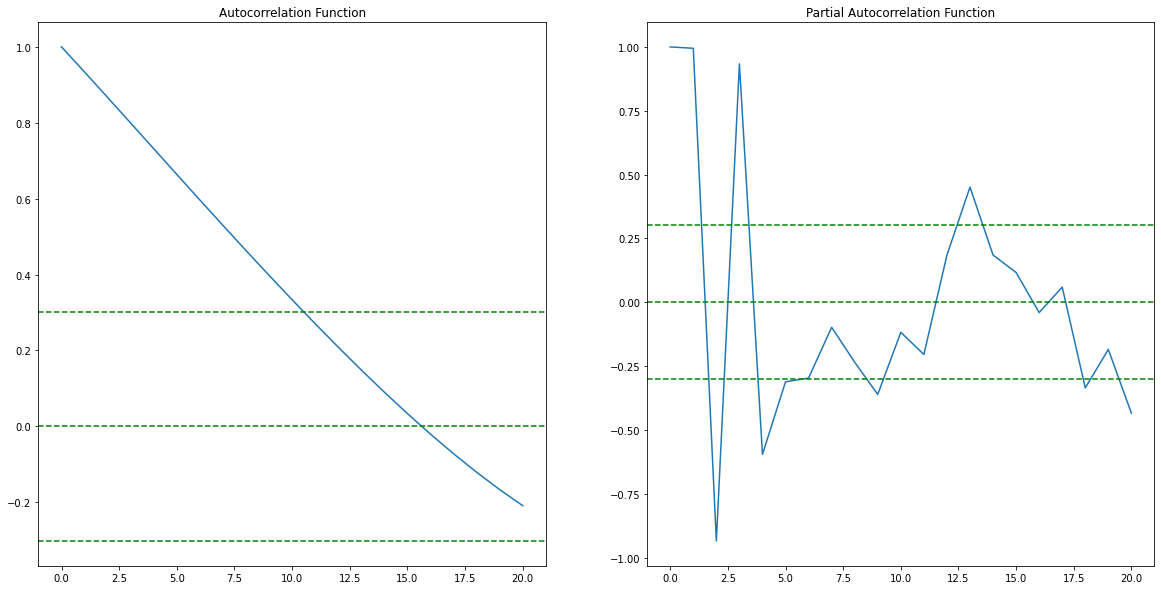

In [238]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(train_df, nlags=20)
lag_pacf=pacf(train_df, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


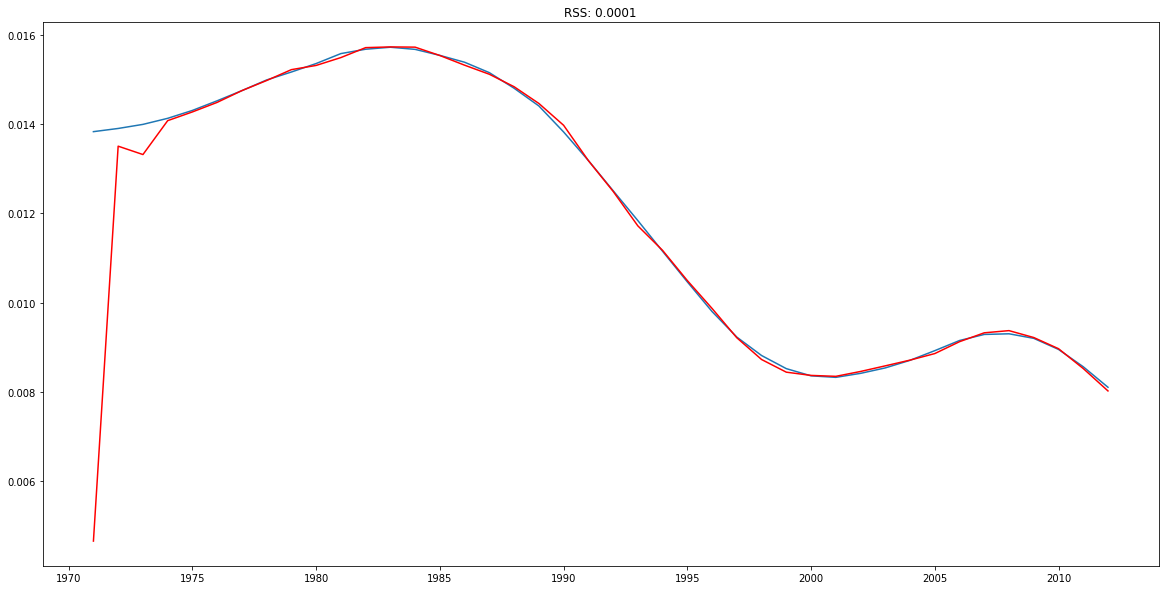

In [239]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(12,1,3))
results=model.fit(disp=-1)
plt.plot(df_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [240]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1971-01-01    0.004661
1972-01-01    0.013506
1973-01-01    0.013318
1974-01-01    0.014077
1975-01-01    0.014273
Freq: AS-JAN, dtype: float64


In [241]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1971-01-01    0.004661
1972-01-01    0.018167
1973-01-01    0.031485
1974-01-01    0.045563
1975-01-01    0.059836
Freq: AS-JAN, dtype: float64


In [242]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [243]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


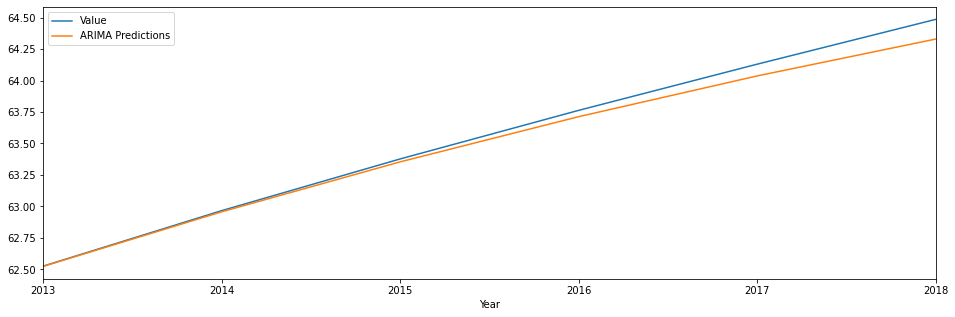

In [244]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [245]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.006052607137886537
RMSE Error: 0.07779850344246049
Mean: 51.838551020408154


In [246]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,64.598190,Afghanistan
2020,64.851341,Afghanistan
2021,65.097875,Afghanistan
2022,65.345473,Afghanistan
2023,65.602994,Afghanistan
2024,65.877222,Afghanistan
2025,66.174063,Afghanistan


In [247]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [248]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,62.525,62.523191
2014-01-01,62.966,62.956810
2015-01-01,63.377,63.353826
2016-01-01,63.763,63.712934
2017-01-01,64.130,64.036622
2018-01-01,64.486,64.329588


**LSTM**

In [264]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [265]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,62.966
2015-01-01,63.377
2016-01-01,63.763
2017-01-01,64.130
2018-01-01,64.486


In [266]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [267]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [268]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [269]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
31/31 [==============================] - 0s 6ms/step - loss: 0.2988
Epoch 2/20
31/31 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 4.9573e-04
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 3.4155e-04
Epoch 6/20
31/31 [==============================] - 0s 7ms/step - loss: 2.5743e-04
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 2.2951e-04
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 1.5301e-04
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 1.9126e-04
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 1.4992e-04
Epoch 11/20
31/31 [==============================] - 0s 6ms/step - loss: 7.3396e-05
Epoch 12/20
31/31 [==============================] - 0s 6ms/step - loss: 3.3436e-05
Epoch 13/20
3

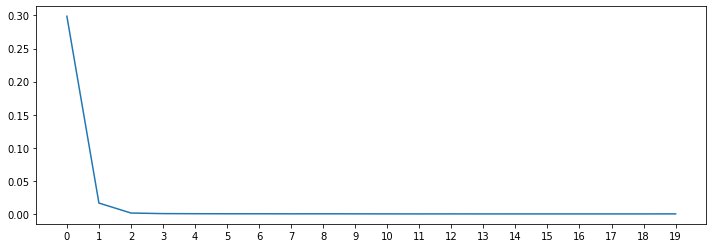

In [270]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [271]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [272]:
lstm_predictions_scaled

[array([1.0117875], dtype=float32),
 array([1.0333298], dtype=float32),
 array([1.0553154], dtype=float32),
 array([1.0777899], dtype=float32),
 array([1.1007496], dtype=float32),
 array([1.1242046], dtype=float32)]

In [273]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [274]:
lstm_predictions

array([[62.34450377],
       [62.87541402],
       [63.41724742],
       [63.97113215],
       [64.53697418],
       [65.11502324]])

In [275]:
test_df['LSTM_Predictions'] = lstm_predictions

In [276]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,62.525,62.523191,62.344504
2014-01-01,62.966,62.956810,62.875414
2015-01-01,63.377,63.353826,63.417247
2016-01-01,63.763,63.712934,63.971132
2017-01-01,64.130,64.036622,64.536974
2018-01-01,64.486,64.329588,65.115023


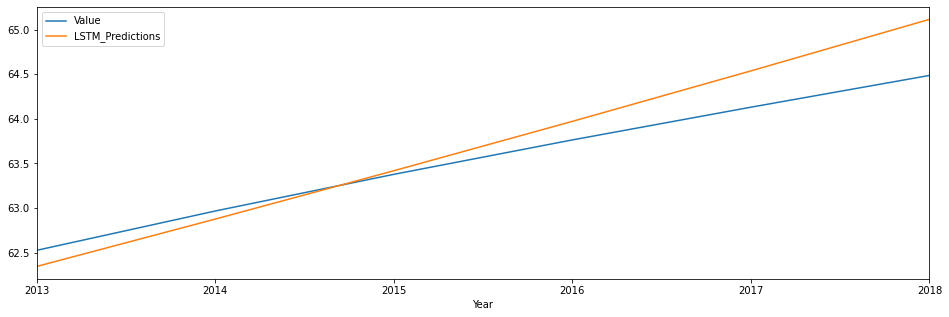

In [277]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [278]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.10783696440951901
RMSE Error: 0.3283853900670963
Mean: 51.838551020408154


In [279]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [280]:
lstm_predictions_scaled

[array([1.0117875], dtype=float32),
 array([1.0333298], dtype=float32),
 array([1.0553154], dtype=float32),
 array([1.0777899], dtype=float32),
 array([1.1007496], dtype=float32),
 array([1.1242046], dtype=float32),
 array([1.1481873], dtype=float32),
 array([1.1726916], dtype=float32),
 array([1.1977649], dtype=float32),
 array([1.2234889], dtype=float32),
 array([1.2499973], dtype=float32),
 array([1.2774984], dtype=float32)]

In [281]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [282]:
lstm_predictions

array([[62.34450377],
       [62.87541402],
       [63.41724742],
       [63.97113215],
       [64.53697418],
       [65.11502324],
       [65.70607551],
       [66.30998408],
       [66.92791531],
       [67.5618846 ],
       [68.21518243],
       [68.89294719]])

In [283]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,65.115023,Afghanistan
2020,65.706076,Afghanistan
2021,66.309984,Afghanistan
2022,66.927915,Afghanistan
2023,67.561885,Afghanistan
2024,68.215182,Afghanistan
2025,68.892947,Afghanistan


In [284]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [285]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
44,2014,62.966
45,2015,63.377
46,2016,63.763
47,2017,64.130
48,2018,64.486


In [286]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
44,2014-01-01,62.966
45,2015-01-01,63.377
46,2016-01-01,63.763
47,2017-01-01,64.130
48,2018-01-01,64.486


In [287]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [288]:
from fbprophet import Prophet

In [289]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [290]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,27.589573,63.120550,63.191406,27.556106,27.622503,35.566864,35.566864,35.566864,35.566864,35.566864,35.566864,0.0,0.0,0.0,63.156437
45,2015-01-01,28.127012,63.625595,63.770251,28.055051,28.199145,35.569616,35.569616,35.569616,35.569616,35.569616,35.569616,0.0,0.0,0.0,63.696629
46,2016-01-01,28.664452,64.106455,64.344789,28.552687,28.783424,35.558850,35.558850,35.558850,35.558850,35.558850,35.558850,0.0,0.0,0.0,64.223302
47,2017-01-01,29.203364,64.608092,64.935070,29.044087,29.372632,35.565409,35.565409,35.565409,35.565409,35.565409,35.565409,0.0,0.0,0.0,64.768773
48,2018-01-01,29.740804,65.092268,65.522762,29.532608,29.956742,35.566864,35.566864,35.566864,35.566864,35.566864,35.566864,0.0,0.0,0.0,65.307668


In [291]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [292]:
prophet_pred = prophet_pred.set_index("Year")

In [293]:
prophet_pred.index.freq = "YS"

In [294]:
prophet_pred

,Pred
Year,
2013-01-01,62.617542
2014-01-01,63.156437
2015-01-01,63.696629
2016-01-01,64.223302
2017-01-01,64.768773
2018-01-01,65.307668


In [295]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,62.525,62.523191,62.344504,62.617542
2014-01-01,62.966,62.956810,62.875414,63.156437
2015-01-01,63.377,63.353826,63.417247,63.696629
2016-01-01,63.763,63.712934,63.971132,64.223302
2017-01-01,64.130,64.036622,64.536974,64.768773
2018-01-01,64.486,64.329588,65.115023,65.307668


In [296]:
import seaborn as sns

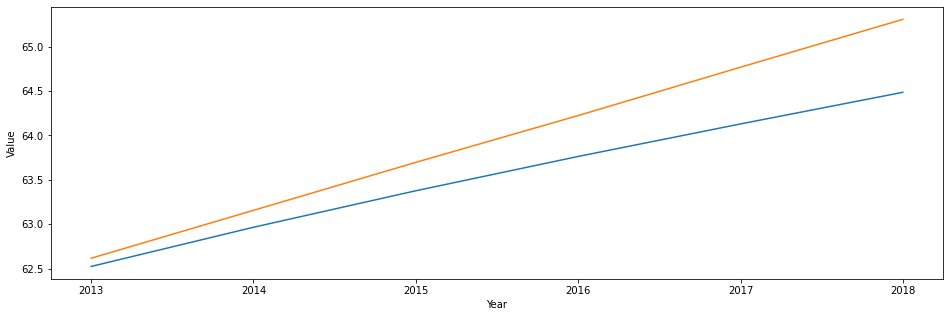

In [297]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [298]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 0.24034008693588502
RMSE Error: 0.4902449254565365
Mean: 51.838551020408154


In [299]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [300]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [301]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,65.847860,Afghanistan
2020,66.374533,Afghanistan
2021,66.920004,Afghanistan
2022,67.458899,Afghanistan
2023,67.999091,Afghanistan
2024,68.525764,Afghanistan
2025,69.071235,Afghanistan


In [302]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [303]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 63.54116666666666


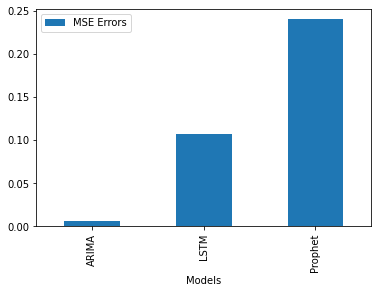

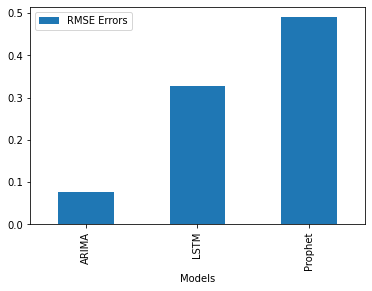

In [304]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [305]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.077799,0.006053,Afghanistan
1,LSTM,0.328385,0.107837,Afghanistan
2,Prophet,0.490245,0.240340,Afghanistan


In [306]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [307]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,62.525,62.523191,62.344504,62.617542,Afghanistan
2014,62.966,62.956810,62.875414,63.156437,Afghanistan
2015,63.377,63.353826,63.417247,63.696629,Afghanistan
2016,63.763,63.712934,63.971132,64.223302,Afghanistan
2017,64.130,64.036622,64.536974,64.768773,Afghanistan
2018,64.486,64.329588,65.115023,65.307668,Afghanistan


In [308]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

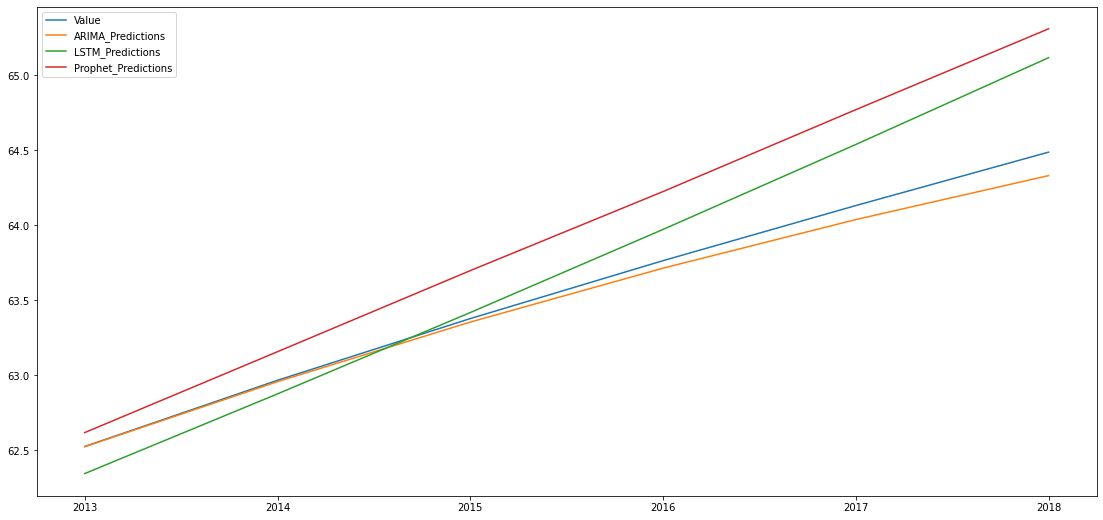

In [309]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))